# Topological comparison of connectomes
This is the main script for topological comparisons interfacing with the [topological_comparator](https://bbpgitlab.epfl.ch/conn/personal/reimann/topological_comparator.git) pipeline, which
 - sets up the topological comparator config files
 - creates a topological database
 - visualizes topological features of the raw and manipulated connectome

> **IMPORTANT:** This notebook is a stand-alone extension to `connectome_manipulator.ipynb`

> **REQUIREMENTS:**
> - BluePy v2 kernel!
> - topological_sampling/common/toposample_utilities/toposample
> - topological_sampling/common/pybind11
> - topological_sampling/common/pyflagsercontain

In [1]:
# Initialization
import sys
import json
import os.path
from pprint import pprint
import importlib  

""" Paths """
sys.path.insert(0, '../pipeline/')
sys.path.insert(0, '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/')

""" Local imports """
from topological_sampling.pipeline.gen_topo_db import gen_topo_db
from topological_sampling.pipeline.count_triads import count_triads
sample_tribes_volumetric = importlib.import_module('topological_sampling.pipeline.sample_tribes.sample-tribes-volumetric') 
from topological_comparator.pipeline import prepare_pipeline
from topological_comparator.pipeline.extract_connectivity import extract_connectivity
from topological_comparator.bin import compare_topo_db
from helper_functions import plot_topodb_comparison
from helper_functions import plot_triads_comparison

In [2]:
# Config selection
topocomp_config_file = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/working_dir/topological_comparator/circuit-build-S1_v1/topocomp_config__Raw_vs_NoManipV2.json' 

In [3]:
# Load configuration from file
with open(topocomp_config_file, 'r') as f:
    topocomp_config = json.load(f)

print(f'INFO: Loaded topocomp_config from {topocomp_config_file}\n')
print('topocomp_config =')
pprint(topocomp_config)

INFO: Loaded topocomp_config from /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/working_dir/topological_comparator/circuit-build-S1_v1/topocomp_config__Raw_vs_NoManipV2.json

topocomp_config =
{'circuits': {'0': {'circuit_config': '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/CircuitConfig',
                    'circuit_name': 'Raw'},
              '1': {'circuit_config': '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1_manip/CircuitConfig_NoManipV2',
                    'circuit_name': 'NoManipV2'}},
 'out_dir': 'figures/circuit-build-S1_v1',
 'working_dir': '../working_dir/topological_comparator/circuit-build-S1_v1'}


In [4]:
# Topological comparison of connectomes - Prepare topological database
topocomp_force_recomp = [False, False]
topocomp_config_files = {}
circuit_ids = sorted(topocomp_config['circuits'].keys())
for cidx in range(len(circuit_ids)):
    wrkdir = os.path.join(topocomp_config['working_dir'], topocomp_config['circuits'][circuit_ids[cidx]]['circuit_name'])
    topocomp_config_files[circuit_ids[cidx]] = os.path.join(wrkdir, 'config', 'common_config.json')
    if os.path.exists(wrkdir) and not topocomp_force_recomp[cidx]:
        print(f'INFO: Folder {wrkdir} already exists ... SKIPPING', flush=True)
    else:
        print(f'INFO: Preparing topological data in {wrkdir}', flush=True)
        # Topological database
        prepare_pipeline.prepare_and_place_files(topocomp_config['circuits'][circuit_ids[cidx]]['circuit_config'], 'All', wrkdir)
        extract_connectivity.main(topocomp_config_files[circuit_ids[cidx]]) # Extract connection matrices
        gen_topo_db.main(topocomp_config_files[circuit_ids[cidx]]) # Create topological database
        
        # Tribe sampling (all neurons) & triplet motifs
        with open(os.path.join(wrkdir, 'config', 'sampling_config.json'), 'w') as f: # Write config to select ALL neurons by volumetric sampling [overwriting existing config]
            json.dump({'Volumetric': {'Specifier_label': 'Radius', 'seed': 100000,
                                      'Specifiers': [{'name': 'All', 'value': 999999999, 'number': 1, 'neuron_count': 999999999}],
                                      'Arguments': {'offset_amplitudes': [0, 0, 0]}}}, f, indent=2)
        sample_tribes_volumetric.main(topocomp_config_files[circuit_ids[cidx]]) # Volumetric sampling
        count_triads.main(topocomp_config_files[circuit_ids[cidx]]) # Compute over-/underexpression of triplet motifs


INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/Raw already exists ... SKIPPING
INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/NoManipV2 already exists ... SKIPPING


In [5]:
# Topological comparison of connectomes - Plot topological paramter overviews
topocomp_db_dict, topocomp_param_dict = compare_topo_db.read_topo_dbs_and_parameter_specs({topocomp_config['circuits'][cidx]['circuit_name']: topocomp_config_files[cidx] for cidx in sorted(topocomp_config_files.keys())})
# TODO: Fix hard-coded "Champions" in read_topo_dbs_and_parameter_specs
plot_topodb_comparison(topocomp_db_dict, topocomp_param_dict, '', topocomp_config['out_dir'], num_rows=3, show_fig=True)
plot_topodb_comparison(topocomp_db_dict, topocomp_param_dict, 'mtype', topocomp_config['out_dir'], num_rows=1, show_fig=True)
plot_topodb_comparison(topocomp_db_dict, topocomp_param_dict, 'layer', topocomp_config['out_dir'], num_rows=2, show_fig=True)


KeyError: 'Champions'

Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_NoManipV2/triad_comp-Radius_All_0.pdf...


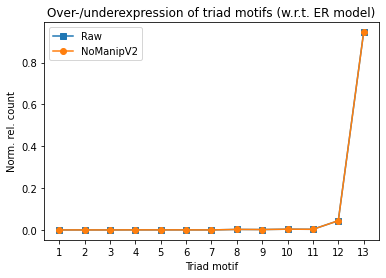

In [6]:
# Topological comparison of connectomes - Plot over-/underexpression of triad motifs
plot_triads_comparison(topocomp_config, topocomp_config_files, 'Radius/All/0', topocomp_config['out_dir'], show_fig=True)